In [188]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import numpy as np
import pandas as pd
import torch_geometric as pyg
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
from tqdm import tqdm
import warnings
from sklearn.exceptions import UndefinedMetricWarning
os.environ["HYDRA_FULL_ERROR"] = "1"
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, human_format, set_seed, identity
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.utils.layers import find_submodule
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead
from mil.models.mil import MILModel
from train import instantiate_loss_function, History, train_step, test

RESULTS_FILE = "train.csv"

GlobalHydra().clear()
hydra.initialize(config_path="conf")
cfg = hydra.compose("config.yaml", overrides=["+experiment=mnist_bags", "+model=self_attention"])
cfg = hydra.compose("config.yaml", overrides=["+experiment=one_hot_mnist_bags", "+model=self_attention"])

set_seed(cfg.seed)

/var/folders/75/85q4yvfd39z3s95j568dmh640000gn/T/ipykernel_93046/4020057011.py:34: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="conf")


# MNIST bags / MNIST collage

## Instantiate datasets and loaders

In [189]:
train_dataset = hydra.utils.instantiate(cfg.dataset.train)
test_dataset = hydra.utils.instantiate(cfg.dataset.test)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [196]:
class DefaultClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x.sum(-2))

class AdditiveClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        instance_logits = self.linear(x).squeeze(-1)
        self.instance_logits = instance_logits.detach()
        return instance_logits.sum(-1)

class ConceptMIL(nn.Module):
    def __init__(self, feature_size: int, num_concepts: int, concept_size: int):
        super().__init__()
        # self.linear = nn.Linear(feature_size, concept_size)
        self.concept_vectors = nn.Parameter(torch.randn(num_concepts, feature_size)) # KxL
        # self.concept_vectors = torch.tensor([
        #     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        #     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        #     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        # ]).float()
        self.concept_biases = nn.Parameter(torch.randn(num_concepts)) # K
        self.out_bias = nn.Parameter(torch.randn(1)) # 1
        self.mlp = nn.Sequential(
            nn.Linear(num_concepts, 1)
        )

    def forward(self, features):
        # features = torch.relu(self.linear(features)) # NxL
        concept_logits = features @ self.concept_vectors.T # NxK
        concept_logits = torch.softmax(concept_logits, dim=-1) # NxK
        concept_excitations = concept_logits.sum(-2)  # K

        self.concept_logits = concept_logits.detach()
        self.concept_excitations = concept_excitations.detach()
        
        # # print(concept_excitations)
        # # Simulate a AND b
        # a, b = concept_excitations[0], concept_excitations[1]
        # self.excitation = a * b + self.out_bias
        # return torch.sigmoid(self.excitation)

        return self.mlp(self.concept_excitations)
        
        
        

model = MILModel(
    feature_extractor=hydra.utils.instantiate(cfg.model.feature_extractor),
    pooler=pyg.nn.Sequential("x, edge_index, edge_attr, pos", [
        (
            # ABMIL(feature_size=cfg.settings.feature_size, hidden_dim=cfg.settings.hidden_dim),
            # MultiHeadSelfAttention(feature_size=cfg.settings.feature_size, hidden_dim=cfg.settings.hidden_dim, output_size=cfg.settings.feature_size),
            ConceptMIL(feature_size=cfg.settings.feature_size, num_concepts=3, concept_size=16),
            "x -> x"
        )
    ]),
    # classifier=DefaultClassifier(input_dim=cfg.settings.feature_size),
    # classifier=AdditiveClassifier(input_dim=cfg.settings.feature_size),
    classifier=torch.nn.Identity(),
    logit_to_prob=torch.sigmoid,
)

# model = hydra.utils.instantiate(cfg.model, _convert_="partial")
attention_layer = find_submodule(model, (WeightedAverageAttention, MultiHeadSelfAttention, DistanceAwareSelfAttentionHead))
classifier = find_submodule(model, (DefaultClassifier, AdditiveClassifier))


## Define loss function and optimizer

We use binary cross-entropy loss.

In [197]:
optimizer = hydra.utils.instantiate(cfg.optimizer, model.parameters())
loss_function = instantiate_loss_function(cfg, train_dataset)
loss_function

2023-06-14 18:18:50.679 | INFO     | train:instantiate_loss_function:142 - Using pos_weight=1.000 in loss function


BCEWithLogitsLoss()

## Train

In [201]:
train_history = History()
test_history = History()
stats = []

model.train()
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training model with {human_format(num_parameters)} parameters")

for epoch in range(cfg.num_epochs):
    model.train()

    train_history.reset()
    test_history.reset()

    # # Biggest bag first to avoid CUDA OOM
    # if isinstance(train_dataset, Camelyon16Dataset):
    #     train_step(
    #         cfg,
    #         -1,
    #         train_dataset.fake_bag(),
    #         model,
    #         loss_function,
    #         optimizer,
    #         history=None,
    #         update=False,
    #     )

    # Train
    for i, bag in enumerate(train_loader):
        train_step(cfg, i, bag, model, loss_function, optimizer, train_history)

    # Test
    predictions = test(cfg, model, loss_function, test_loader, test_history, pbar=False, return_predictions=True)

    log = {
        "epoch": epoch,
        **{f"train/{k}": v for k, v in train_history.compute_metrics().items()},
        **{f"test/{k}": v for k, v in test_history.compute_metrics().items()},
    }
    stats.append(log)
    LOG_KEYS = {"train/acc", "test/acc", "train/loss", "test/loss"}
    print(
        f"Epoch: {epoch:3d},",
        ", ".join(
            f"{k}: {v:.4f}" for k, v in log.items() if k in LOG_KEYS
        ),
    )

# Plot training and test loss/error
stats = pd.DataFrame(stats)
float_cols = [col for col in stats.columns if col != "epoch"]
stats[float_cols] = stats[float_cols].astype(float)
stats.to_csv(RESULTS_FILE, index=False)

Training model with 38 parameters
Epoch:   0, train/acc: 0.7133, train/loss: 0.5841, test/acc: 0.6900, test/loss: 0.5905
Epoch:   1, train/acc: 0.7133, train/loss: 0.5835, test/acc: 0.7000, test/loss: 0.5896
Epoch:   2, train/acc: 0.7033, train/loss: 0.5836, test/acc: 0.7000, test/loss: 0.5900
Epoch:   3, train/acc: 0.7000, train/loss: 0.5823, test/acc: 0.6900, test/loss: 0.5902
Epoch:   4, train/acc: 0.7067, train/loss: 0.5838, test/acc: 0.7000, test/loss: 0.5892
Epoch:   5, train/acc: 0.6900, train/loss: 0.5822, test/acc: 0.7100, test/loss: 0.5905
Epoch:   6, train/acc: 0.7100, train/loss: 0.5812, test/acc: 0.7100, test/loss: 0.5904
Epoch:   7, train/acc: 0.7033, train/loss: 0.5809, test/acc: 0.7000, test/loss: 0.5913
Epoch:   8, train/acc: 0.7033, train/loss: 0.5812, test/acc: 0.7000, test/loss: 0.5893
Epoch:   9, train/acc: 0.7100, train/loss: 0.5810, test/acc: 0.7000, test/loss: 0.5886
Epoch:  10, train/acc: 0.7033, train/loss: 0.5805, test/acc: 0.7000, test/loss: 0.5885
Epoch:  1

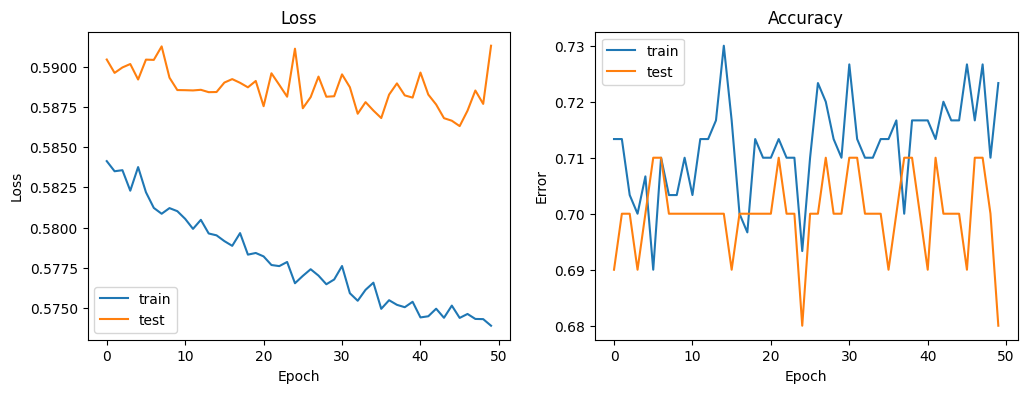

In [202]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["train/loss"], label="train")
plt.plot(stats["epoch"], stats["test/loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Accuracy")
plt.plot(stats["epoch"], stats["train/acc"], label="train")
plt.plot(stats["epoch"], stats["test/acc"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

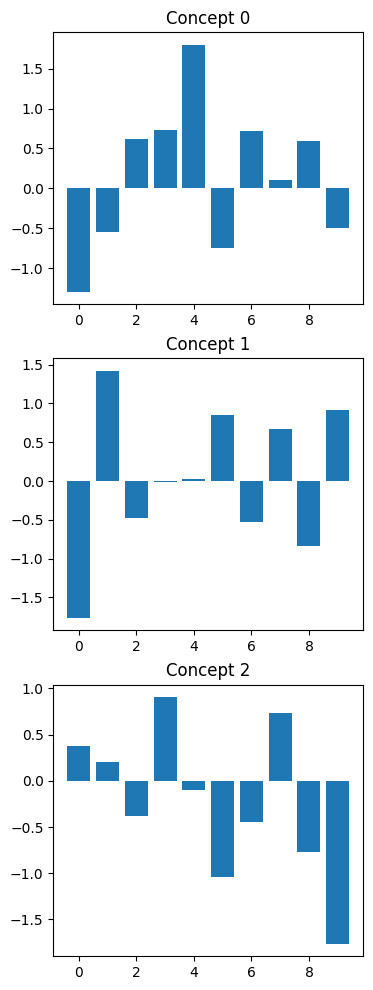

In [203]:
concept_mil = find_submodule(model, ConceptMIL)

plt.figure(figsize=(4, 12))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.title(f"Concept {i}")
    plt.bar(range(10), concept_mil.concept_vectors[i].detach().numpy())

In [172]:
for i, bag in enumerate(train_loader):
    if i == 0:
        break

y_pred, y_pred_logit = model(bag)

print(f"pred: {y_pred:.2f}, real: {bag.y}")
print(concept_mil.concept_logits)
print(concept_mil.concept_excitations)
print(concept_mil.excitation)
print(concept_mil.out_bias.item())

pred: 0.17, real: 1.0
tensor([[1.3360e-03, 9.9716e-01, 1.5077e-03],
        [9.9164e-01, 7.5693e-03, 7.9291e-04],
        [7.9545e-01, 8.7829e-02, 1.1672e-01],
        [7.9545e-01, 8.7829e-02, 1.1672e-01],
        [2.6475e-01, 5.3417e-02, 6.8183e-01],
        [9.3777e-01, 1.1339e-02, 5.0888e-02]])
tensor([0.6311, 0.2075, 0.1614])
tensor([-1.5860], grad_fn=<AddBackward0>)
-1.7169197797775269


## Test

In [22]:
print_prediction_stats(predictions, target_numbers=cfg.settings.mnist.target_numbers)


                                 % acc    total    -pred    +pred     example
  bags                              50      100      100        0     0 8 8 5 6 0 3 6 4 9
  bags with 0s                      29       71       71        0     0 8 8 5 6 0 3 6 4 9
  bags without 0s                  100       29       29        0     9 3 1 2 8 9
  bags with 0s and 1s                0       50       50        0     0 3 5 9 0 3 6 5 1 1 8
  bags with 0s and not 1s          100       21       21        0     0 8 8 5 6 0 3 6 4 9
  bags with 0s or 1s                46       93       93        0     0 8 8 5 6 0 3 6 4 9
  bags with 1s                      30       72       72        0     0 3 5 9 0 3 6 5 1 1 8
  bags without 1s                  100       28       28        0     0 8 8 5 6 0 3 6 4 9
  bags with 1s and 0s                0       50       50        0     0 3 5 9 0 3 6 5 1 1 8
  bags with 1s and not 0s          100       22       22        0     9 3 1 2 8 9
  bags with 1s or 0s           

### First 10 bags in test dataset

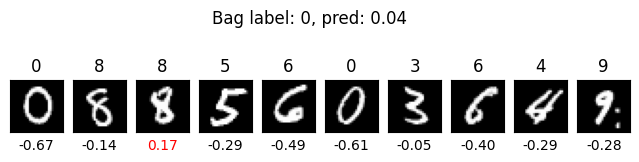

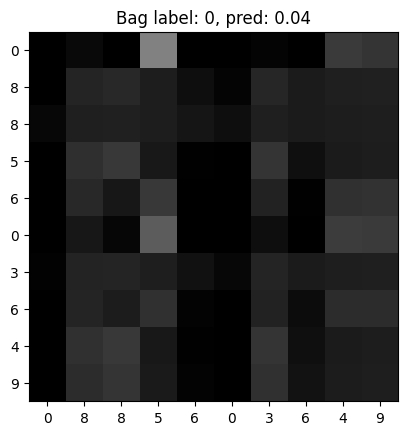

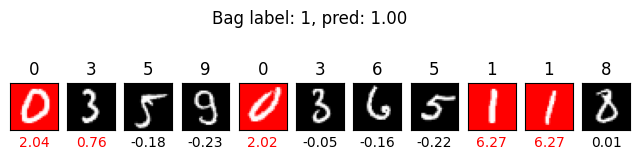

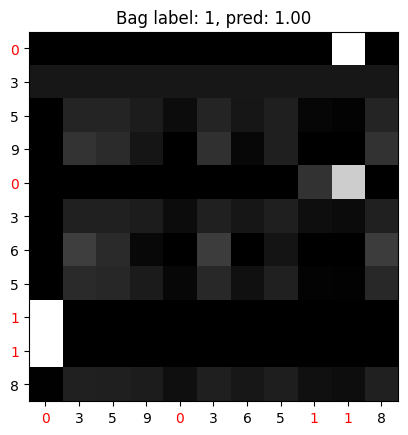

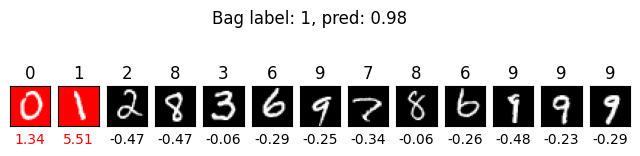

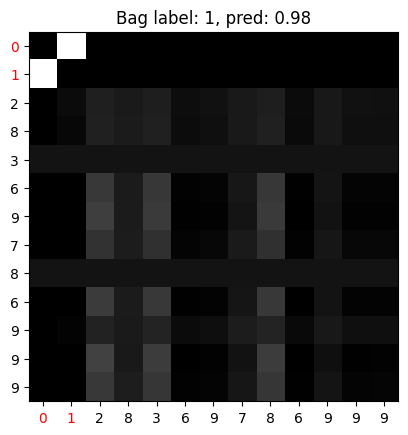

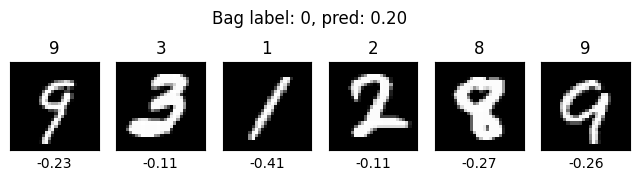

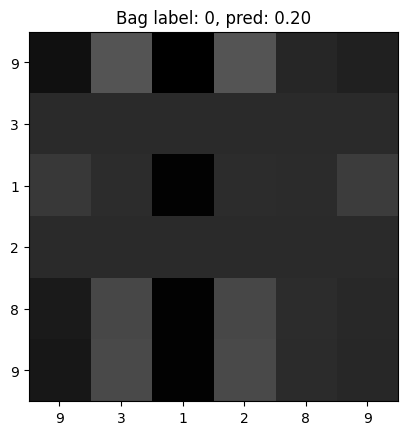

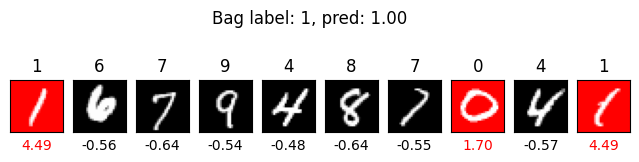

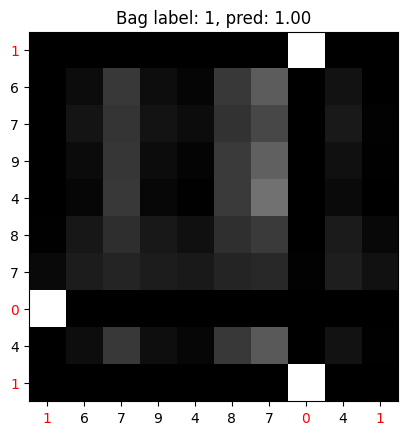

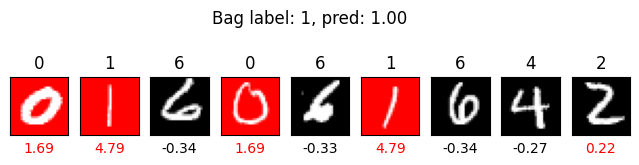

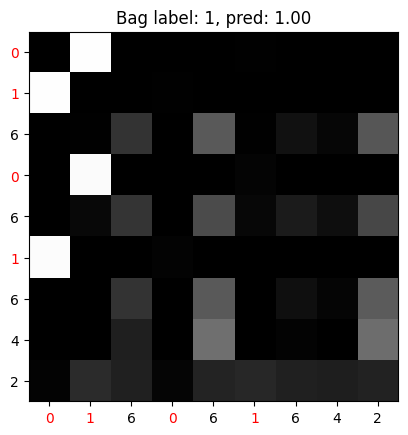

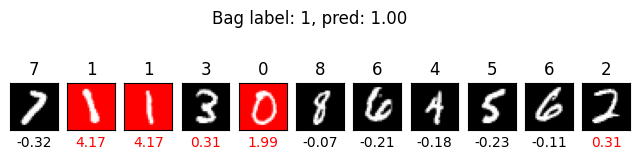

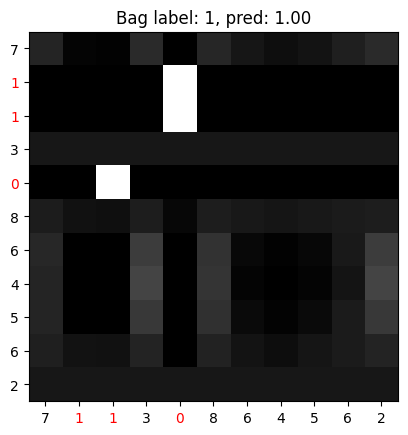

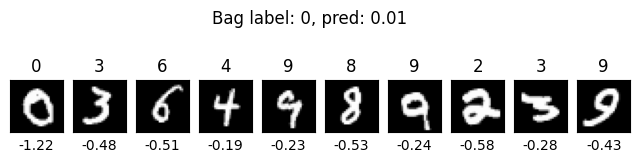

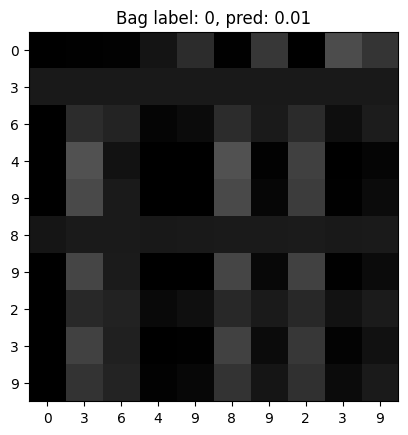

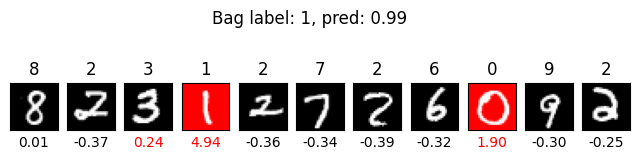

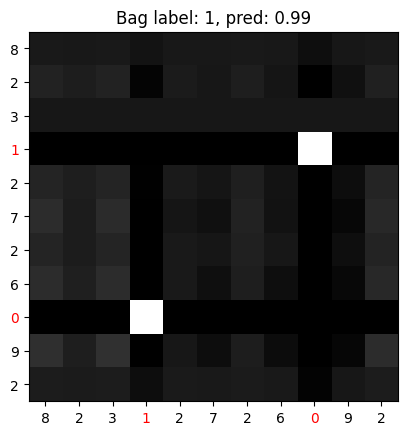

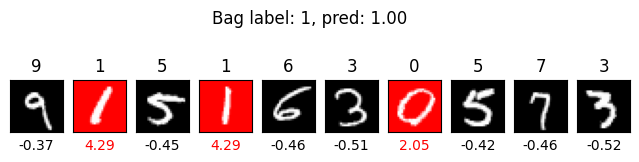

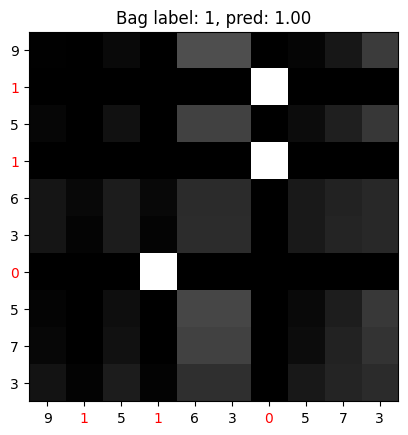

In [9]:
def plot_dist_aware_attention(bag):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(141)
    plt.title("dist")
    data = attention_layer.data
    dist = pyg.utils.to_dense_adj(data.edge_index, edge_attr=data.edge_attr.squeeze(-1), max_num_nodes=data.num_nodes).squeeze(0)  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    plt.subplot(142)
    plt.title("A0")
    plot_attention_head(bag, attention_layer.A0)
    plt.subplot(143)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

def visualize_prediction(bag, y_pred):
    y = bag.y
    if isinstance(train_dataset, OneHotMNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadSelfAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif isinstance(train_dataset, MNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadSelfAttention):
            attention = None
            if isinstance(classifier, AdditiveClassifier):
                attention = classifier.instance_logits
            plot_bag(bag, y_pred=y_pred, attention=attention)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif isinstance(train_dataset, OneHotMNISTCollage):
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)
    elif isinstance(train_dataset, MNISTCollage):
        plot_bag(bag, y_pred=y_pred, collage_size=COLLAGE_SIZE)
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.y.float()
        y_pred, y_pred_logit = model(bag)
        visualize_prediction(bag, y_pred.squeeze(0))

### First 10 mistakes in test dataset

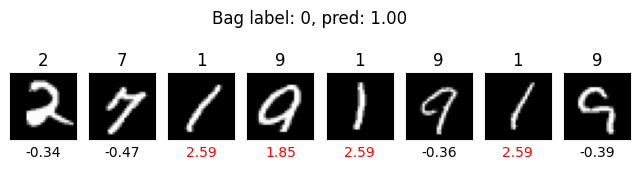

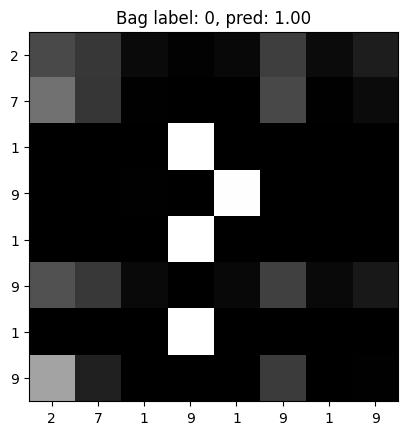

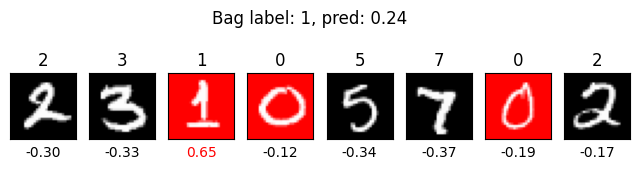

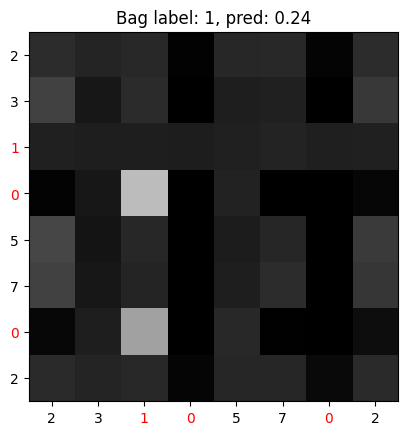

In [13]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.y.float()
        y_pred, y_pred_logit = model(bag)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred.squeeze(0))
            i += 1